<a href="https://colab.research.google.com/github/iakioh/MusiCAN/blob/main/models/musiCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')  

Mounted at /content/drive/


In [2]:
# Go to this notebook's directory
repo_path = "/content/drive/MyDrive/MusiCAN/"
%cd {repo_path}/models

/content/drive/MyDrive/MusiCAN/models


In [3]:
# Check GPU connection
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep 20 10:57:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Check RAM access
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
# Install muspy related code
!pip install muspy
import muspy
muspy.download_musescore_soundfont() 
muspy.download_bravura_font() 

# Install fluidsynth related code
!apt install fluidsynth
!pip install pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 119 kB 7.0 MB/s 
     |████████████████████████████████| 5.6 MB 20.3 MB/s 
     |████████████████████████████████| 22.4 MB 62.0 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=86f3e13cec99a21ab818f043ff530b2b48ad7836136faced05ffbe7eda2c2676
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0
Start downloading MuseScore General soundfont.
MuseScore General soundfont has successfully been downloaded to : /root/.muspy/musescore-general.
Start downloading Bravura font.
Bravura font has successfully been dow

# musiGAN

**Description:** 1-Track MuseGAN architecture build on MiniGAN.\
**Purpose:** implement a composing GAN.\
**Results:**

In [6]:
import os
import pickle
from tqdm import notebook
from datetime import datetime
from IPython.display import Audio, display

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

import math
import numpy as np
import torch
from scipy import ndimage

import muspy
import fluidsynth

## Data Preparation

In [7]:
class Pianoroll :
    def __init__ (self, filepath, bars, lowest_pitch, genre_list) :
        assert  type(filepath) == str

        # Creating the dataset from a file
        stored_data  = np.load(filepath)
        data_array   = stored_data["data"]
        labels_array = stored_data["labels"]

        ## Split dataset into training and test parts
        np.random.seed(seed=902741)
        perm         = np.random.permutation(len(labels_array))
        data_array   = data_array[perm]
        labels_array = labels_array[perm]
        split_line   = len(labels_array) // 11
        data_test, data     = np.array_split(data_array, [split_line], axis = 0)
        labels_test, labels = np.array_split(labels_array, [split_line], axis = 0)

        # Making a torch dataset
        self.data   = torch.as_tensor(data, dtype = torch.float32)
        self.labels = torch.as_tensor(labels, dtype = torch.int64)
        self.data_test   = torch.as_tensor(data_test, dtype = torch.float32)
        self.labels_test = torch.as_tensor(labels_test, dtype = torch.int64)

        self.dataset      = torch.utils.data.TensorDataset(self.data, 
                                                           self.labels)
        self.dataset_test = torch.utils.data.TensorDataset(self.data_test, 
                                                           self.labels_test)

        # Storing additional info about it
        self.shape  = tuple(self.data.shape[1:])   # shape of one pianoroll image
        self.size   = self.shape[0] * self.shape[1]
        self.height       = self.data.shape[2]
        self.width        = self.data.shape[1]
        self.dataset_size = self.data.shape[0]
        self.test_size    = self.data_test.shape[0]

        self.bars         = bars
        self.lowest_pitch = lowest_pitch
        self.genre_list   = genre_list

        self.blips_per_bar  = self.width // self.bars
        self.blips_per_beat = self.blips_per_bar // 4
        self.pitches        = self.height
        self.octaves        = self.pitches // 12
        self.n_labels       = len(self.genre_list)

    
    def show (self, number = None) :
        if number == None :
            number = np.random.randint(self.dataset_size)
        else :
            assert  type(number) == int
            assert  number >= 0 and number < self.dataset_size

        plt.figure(figsize = (12, 6))
        plt.title(f"pianoroll #{number}")
        plt.imshow(self.data[number].T)
        plt.show()

### LPD5

In [8]:
default_training_path = "../experiments"

#default_dataset       = "lpd5_full_4bars"
default_dataset       = "datacombi_1"

In [9]:
lpd5_path = "../experiments/lpd5_full_4bars/prepared_arrays.npz"
lpd5_bars = 4
lpd5_lowest_pitch = 24
lpd5_genre_list = ['Rap', 'Latin', 'International', 'Electronic', 
                   'Country', 'Folk', 'Blues', 'Reggae', 'Jazz',
                   'Vocal', 'New-Age', 'RnB', 'Pop_Rock']
#lpd5 = Pianoroll(lpd5_path, lpd5_bars, lpd5_lowest_pitch, lpd5_genre_list)

In [10]:
dc1_path = "../experiments/datacombi_1/prepared_arrays.npz"
dc1_bars = 4 # actually 12 but 4 for gen and dis compatibiliy reasons.
dc1_lowest_pitch = 24
dc1_genre_list   = ['Latin', 'Electronic', 'Country', 'RnB', 'Pop_Rock', 'Classical', 'Game']

lpd5 = Pianoroll(dc1_path, dc1_bars, dc1_lowest_pitch, dc1_genre_list)

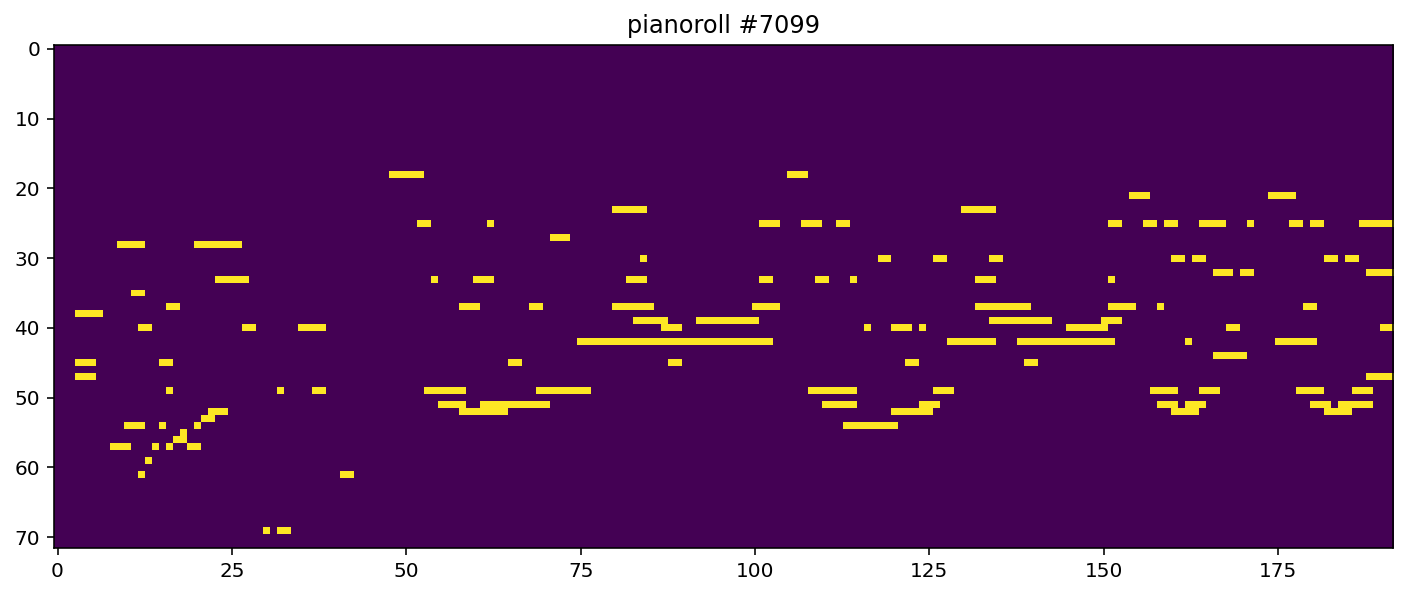

In [11]:
lpd5.show()

In [12]:
print("lpd5.dataset_size", lpd5.dataset_size)
print("lpd5.test_size", lpd5.test_size)
print("lpd5.shape", lpd5.shape)

lpd5.dataset_size 35170
lpd5.test_size 3517
lpd5.shape (192, 72)


In [13]:
print("lpd5.bars", lpd5.bars)
print("lpd5.blips_per_bar", lpd5.blips_per_bar)
print("lpd5.pitches", lpd5.pitches)
print("lpd5.octaves", lpd5.octaves)

lpd5.bars 4
lpd5.blips_per_bar 48
lpd5.pitches 72
lpd5.octaves 6


In [14]:
print("lpd5.n_labels", lpd5.n_labels)
print("lpd5.genre_list", lpd5.genre_list)

lpd5.n_labels 7
lpd5.genre_list ['Latin', 'Electronic', 'Country', 'RnB', 'Pop_Rock', 'Classical', 'Game']


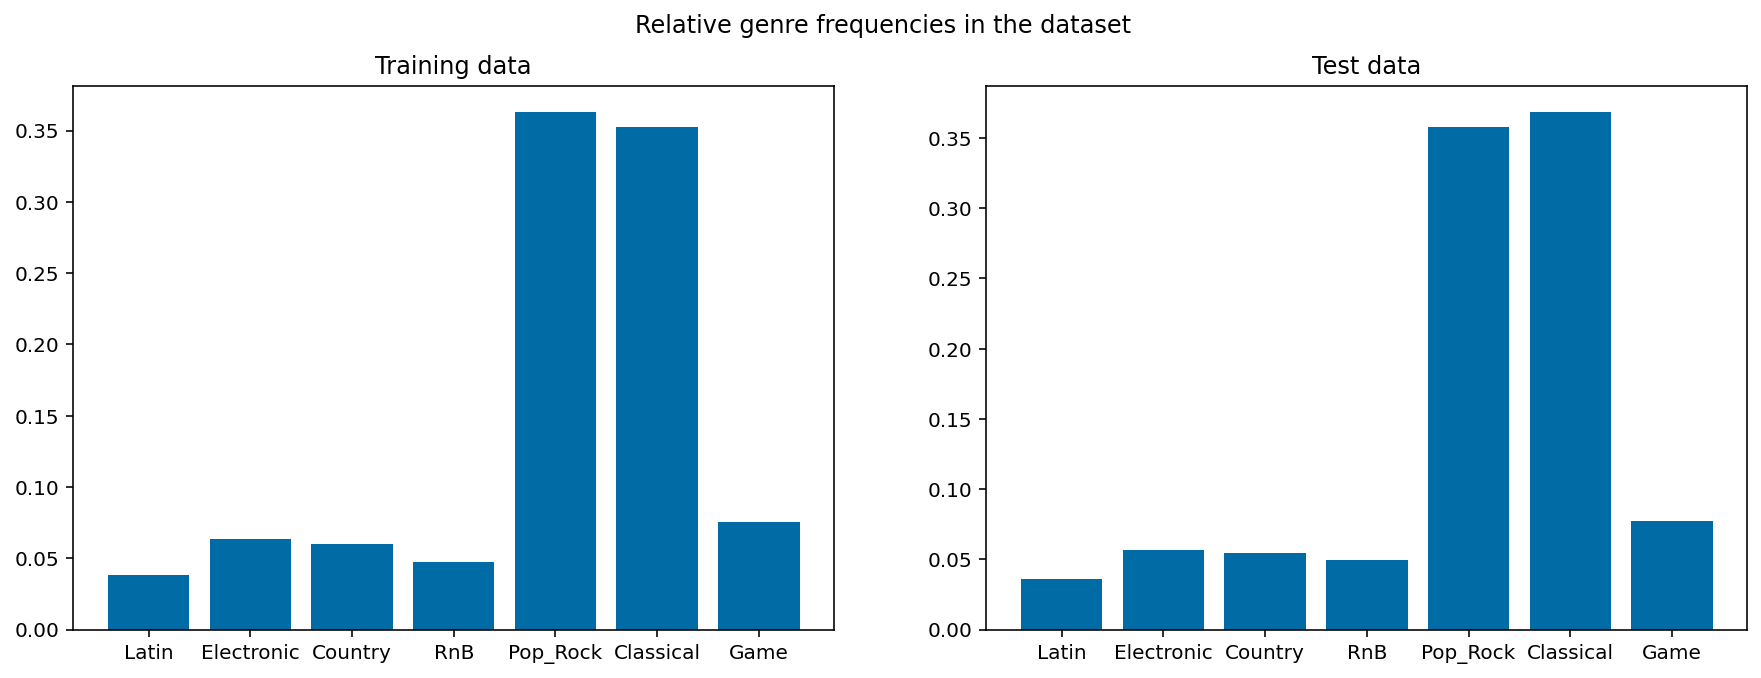

In [15]:
plt.figure(figsize = (15, 5))
plt.suptitle("Relative genre frequencies in the dataset")
x_pos = np.arange(lpd5.n_labels)

plt.subplot(1, 2, 1)
plt.title("Training data")
label_freqs = np.array([np.mean(lpd5.labels.numpy() == i) 
                        for i in range(lpd5.n_labels)])
plt.bar(x_pos, label_freqs, tick_label = lpd5.genre_list)

plt.subplot(1, 2, 2)
plt.title("Test data")
label_freqs_test = np.array([np.mean(lpd5.labels_test.numpy() == i) 
                             for i in range(lpd5.n_labels)])
plt.bar(np.arange(lpd5.n_labels), label_freqs_test, tick_label = lpd5.genre_list)

plt.show()

In [16]:
rel_diff = label_freqs / label_freqs_test - 1
print("Relative difference in genre frequencies of test compared to training data:")
for diff, genre in zip(rel_diff, lpd5.genre_list) :
    print(f"{genre:10} : {diff*100:4.1f}%")

Relative difference in genre frequencies of test compared to training data:
Latin      :  6.9%
Electronic : 11.1%
Country    : 10.9%
RnB        : -3.8%
Pop_Rock   :  1.4%
Classical  : -4.4%
Game       : -2.4%


## Architecture classes

### Support classes

In [17]:
"""
    These two classes serves as torch layers to binarize the output of the Generator while keeping the layer still "backpropagatable" (via a hardtanh).
    This is not our own code. For source, see:
    https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html#:~:text=A%20straight%2Dthrough%20estimator%20is,function%20was%20an%20identity%20function.
"""

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0.5).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

class StraightThroughEstimator(torch.nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        # only binarize in eval() mode, not in training
        x = x  if self.training  else  STEFunction.apply(x)
        #x = STEFunction.apply(x)
        return x


In [18]:
class GeneratorBlock(torch.nn.Module):
    """ 2d transconv layer, batch normalization & ReLU """

    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()

        self.gen_block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_dim, out_dim, kernel, stride),
            torch.nn.BatchNorm2d(out_dim),
            torch.nn.ReLU()
            )

    def forward(self, x):
        return self.gen_block(x)

In [19]:
class DiscriminatorBlock(torch.nn.Module):
    """3d conv layer & Leaky ReLU"""

    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.dis_block = torch.nn.Sequential(
            torch.nn.Conv3d(in_dim, out_dim, kernel, stride),
            torch.nn.LeakyReLU(negative_slope = 0.2)   # MuseGAN Hyperparameter
            )

    def forward(self, x):
        return self.dis_block(x)

### Main neural network classes

In [20]:
class MusiGen (torch.nn.Module) :
    """
    1-track museGAN generator, consisting of two sub-networks (so-called 
    temporal and bar generator)

    input : seed vector, a normally distributed random vector, 
            length: (B + 1) * 64 = 5 * 64 here
    output: pianaroll, binary tensor, shape: (B x T x P) = (4 x 48 x 84) here
    """

    def __init__ (self, log = False, **kwargs) : 
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        self.seedlength = 64
        
        self.temporal_generator = torch.nn.Sequential(
            
            # heuristically added linear layer
            torch.nn.Linear(1, 31),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),

            # transconv layer 1
            torch.nn.ConvTranspose1d(64, 1024, 2, 2),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),

            # transconv layer 2
            torch.nn.ConvTranspose1d(1024, 1, 3, 1),
            torch.nn.BatchNorm1d(1),
            torch.nn.ReLU()
        )

        self.bar_generator = torch.nn.Sequential(
            
            # transconv layers
            GeneratorBlock( 128, 1024, (2, 1), (2, 1)),
            GeneratorBlock(1024,  512, (2, 1), (2, 1)),
            GeneratorBlock( 512,  256, (2, 1), (2, 1)),
            GeneratorBlock( 256,  256, (2, 1), (2, 1)),
            GeneratorBlock( 256,  128, (3, 1), (3, 1)),
            GeneratorBlock( 128,   64, (1, self.octaves), (1, self.octaves)),

            # last layer with tanh & binarization activation fct.s
            torch.nn.ConvTranspose2d(64, 1, (1, 12), (1, 12)),
            torch.nn.BatchNorm2d(1),
            torch.nn.Tanh(),
            StraightThroughEstimator() # binarization
        )
        

        if log :
            print(f"Generator: parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def forward_custom (self, seed) :
        assert  type(seed) == torch.Tensor
        assert  len(seed.shape) == 2
        assert  seed.shape[0] >= 1
        assert  seed.shape[1] == (1 + self.bars) * self.seedlength

        batchsize = seed.shape[0]
        return self.forward(batchsize, seed)


    def forward (self, batch_size, seed = None) :
        
        if seed == None :
            assert type(batch_size) == int
            assert batch_size >= 1
            device = 'cuda'  if torch.cuda.is_available() else  'cpu'
            seed = torch.normal(0., 1, (batch_size, (1 + self.bars) * self.seedlength)).to(device)
            
        seeds = torch.chunk(seed, chunks = 5, dim = 1)
        
        # create time-independent first half of seed for bar generator
        bar_seed_1 = seeds[0]
        bar_seed_1 = bar_seed_1.view((-1, self.seedlength, 1, 1)) # reshape for transconv layers

        # generate pianorolls bar by bar
        generated_bars = []
        for temporal_seed in seeds[1:]:
            
            ## generate time-dependent second half of seed for bar generator

            temporal_seed = temporal_seed.view(-1, self.seedlength, 1) # reshape for transconv layers
            #print(f"temporal seed: {temporal_seed.size()}")
            bar_seed_2 = self.temporal_generator(temporal_seed) # (batch size x 1 x 64)
            #print(f"bar seed 2: {bar_seed_2.size()}")

            ## reshape & concatenate both halfs of seed for bar generator 
            
            bar_seed_2 = bar_seed_2.view(-1, self.seedlength, 1, 1)
            bar_seed   = torch.cat((bar_seed_1, bar_seed_2), dim = 1) # (batch size x 128 x 1 x 1)
            #print(f"bar seed: {bar_seed d.size()}")

            ## generate one bar 
            
            generated_bar = self.bar_generator(bar_seed) # (batch size x 1 x 24 x 84)
            #print(f"generated_bar: {generated_bar.size()}")
            generated_bars.append(generated_bar) 

        pianoroll = torch.cat(generated_bars, dim = 1) # (batch size x 4 x 24 x 84) 
        #print(f"gen output: {pianoroll.size()}")

        return pianoroll

In [21]:
class MusiGenMod1 (torch.nn.Module) :
    """
    1-track museGAN generator, consisting of two sub-networks (so-called 
    temporal and bar generator)

    input : seed vector, a normally distributed random vector, 
            length: (B + 1) * 64 = 5 * 64 here
    output: pianaroll, binary tensor, shape: (B x T x P) = (4 x 48 x 84) here
    """

    def __init__ (self, log = False, **kwargs) : 
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        self.seedlength = 64
        
        self.temporal_generator = torch.nn.Sequential(
            
            # heuristically added linear layer
            torch.nn.Linear(1, 31),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),

            # transconv layer 1
            torch.nn.ConvTranspose1d(64, 1024, 2, 2),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),

            # transconv layer 2
            torch.nn.ConvTranspose1d(1024, 1, 3, 1),
            torch.nn.BatchNorm1d(1),
            torch.nn.ReLU()
        )

        self.bar_generator = torch.nn.Sequential(
            
            # transconv layers
            GeneratorBlock( 128, 1024, (3, 1), (3, 1)),
            GeneratorBlock(1024,  512, (2, 1), (2, 1)),
            GeneratorBlock( 512,  256, (1, self.octaves), (1, self.octaves)),
            GeneratorBlock( 256,  256, (1, 12), (1, 12)),
            GeneratorBlock( 256,  128, (2, 1), (2, 1)),
            GeneratorBlock( 128,   64, (2, 1), (2, 1)),

            # last layer with tanh & binarization activation fct.s
            torch.nn.ConvTranspose2d(64, 1, (2, 1), (2, 1)),
            torch.nn.BatchNorm2d(1),
            torch.nn.Tanh(),
            StraightThroughEstimator() # binarization
        )

        if log :
            print(f"Generator: parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def forward_custom (self, seed) :
        assert  type(seed) == torch.Tensor
        assert  len(seed.shape) == 2
        assert  seed.shape[0] >= 1
        assert  seed.shape[1] == (1 + self.bars) * self.seedlength

        batchsize = seed.shape[0]
        return self.forward(batchsize, seed)


    def forward (self, batch_size, seed = None) :
        
        if seed == None :
            assert type(batch_size) == int
            assert batch_size >= 1
            device = 'cuda'  if torch.cuda.is_available() else  'cpu'
            seed = torch.normal(0., 1, (batch_size, (1 + self.bars) * self.seedlength)).to(device)
            
        seeds = torch.chunk(seed, chunks = 5, dim = 1)
        
        # create time-independent first half of seed for bar generator
        bar_seed_1 = seeds[0]
        bar_seed_1 = bar_seed_1.view((-1, self.seedlength, 1, 1)) # reshape for transconv layers

        # generate pianorolls bar by bar
        generated_bars = []
        for temporal_seed in seeds[1:]:
            
            ## generate time-dependent second half of seed for bar generator

            temporal_seed = temporal_seed.view(-1, self.seedlength, 1) # reshape for transconv layers
            #print(f"temporal seed: {temporal_seed.size()}")
            bar_seed_2 = self.temporal_generator(temporal_seed) # (batch size x 1 x 64)
            #print(f"bar seed 2: {bar_seed_2.size()}")

            ## reshape & concatenate both halfs of seed for bar generator 
            
            bar_seed_2 = bar_seed_2.view(-1, self.seedlength, 1, 1)
            bar_seed   = torch.cat((bar_seed_1, bar_seed_2), dim = 1) # (batch size x 128 x 1 x 1)
            #print(f"bar seed: {bar_seed d.size()}")

            ## generate one bar 
            
            generated_bar = self.bar_generator(bar_seed) # (batch size x 1 x 24 x 84)
            #print(f"generated_bar: {generated_bar.size()}")
            generated_bars.append(generated_bar) 

        pianoroll = torch.cat(generated_bars, dim = 1) # (batch size x 4 x 24 x 84) 
        #print(f"gen output: {pianoroll.size()}")

        return pianoroll

In [22]:
class MusiGenMod2 (torch.nn.Module) :
    """
    1-track museGAN generator, consisting of two sub-networks (so-called 
    temporal and bar generator)

    input : seed vector, a normally distributed random vector, 
            length: (B + 1) * 64 = 5 * 64 here
    output: pianaroll, binary tensor, shape: (B x T x P) = (4 x 48 x 84) here
    """

    def __init__ (self, log = False, **kwargs) : 
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        self.seedlength = 128
        
        self.temporal_generator = torch.nn.Sequential(
            
            # heuristically added linear layer
            torch.nn.Linear(1, 31),
            torch.nn.BatchNorm1d(self.seedlength),
            torch.nn.ReLU(),

            # transconv layer 1
            torch.nn.ConvTranspose1d(self.seedlength, 512, 2, 2),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),

            # transconv layer 2
            torch.nn.ConvTranspose1d(512, 1024, 2, 2),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),

            # transconv layer 3
            torch.nn.ConvTranspose1d(1024, 1, 5, 1),
            torch.nn.BatchNorm1d(1),
            torch.nn.ReLU()
        )

        self.bar_generator = torch.nn.Sequential(
            
            # transconv layers
            GeneratorBlock( 2*self.seedlength, 1024, (2, 1), (2, 1)),
            GeneratorBlock(1024,  512, (2, 1), (2, 1)),
            GeneratorBlock( 512,  256, (1, self.octaves), (1, self.octaves)),
            GeneratorBlock( 256,  256, (1, 4), (1, 4)),
            GeneratorBlock( 256,  256, (1, 3), (1, 3)),
            GeneratorBlock( 256,  128, (3, 1), (3, 1)),
            GeneratorBlock( 128,   64, (2, 1), (2, 1)),

            # last layer with tanh & binarization activation fct.s
            torch.nn.ConvTranspose2d(64, 1, (2, 1), (2, 1)),
            torch.nn.BatchNorm2d(1),
            torch.nn.Tanh(),
            StraightThroughEstimator() # binarization
        )

        if log :
            print(f"Generator: parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def forward (self, batch_size, seed = None) :
        
        if seed == None :
            assert type(batch_size) == int
            assert batch_size >= 1
            device = 'cuda'  if torch.cuda.is_available() else  'cpu'
            seed = torch.normal(0., 1, (batch_size, (1 + self.bars) * self.seedlength)).to(device)
            
        seeds = torch.chunk(seed, chunks = 5, dim = 1)
        
        # create time-independent first half of seed for bar generator
        bar_seed_1 = seeds[0]
        bar_seed_1 = bar_seed_1.view((-1, self.seedlength, 1, 1)) # reshape for transconv layers

        # generate pianorolls bar by bar
        generated_bars = []
        for temporal_seed in seeds[1:]:
            
            ## generate time-dependent second half of seed for bar generator

            temporal_seed = temporal_seed.view(-1, self.seedlength, 1) # reshape for transconv layers
            #print(f"temporal seed: {temporal_seed.size()}", temporal_seed.device)
            #print(f"temporal generator: {self.temporal_generator[0].device}")
            bar_seed_2 = self.temporal_generator(temporal_seed) # (batch size x 1 x 128)
            #print(f"bar seed 2: {bar_seed_2.size()}")

            ## reshape & concatenate both halfs of seed for bar generator 
        
            bar_seed_2 = bar_seed_2.view(-1, self.seedlength, 1, 1)
            bar_seed   = torch.cat((bar_seed_1, bar_seed_2), dim = 1) # (batch size x 256 x 1 x 1)
            #print(f"bar seed: {bar_seed.size()}")

            ## generate one bar 
            
            generated_bar = self.bar_generator(bar_seed) # (batch size x 1 x 48 x 84)
            #print(f"generated_bar: {generated_bar.size()}")
            generated_bars.append(generated_bar) 

        pianoroll = torch.cat(generated_bars, dim = 1) # (batch size x 4 x 48 x 84) 
        #print(f"gen output: {pianoroll.size()}")

        return pianoroll

In [23]:
class MusiGenMod3 (torch.nn.Module) :
    """
    1-track museGAN generator, consisting of two sub-networks (so-called 
    temporal and bar generator)

    input : seed vector, a normally distributed random vector, 
            length: (B + 1) * 64 = 5 * 64 here
    output: pianaroll, binary tensor, shape: (B x T x P) = (4 x 48 x 84) here
    """

    def __init__ (self, log = False, **kwargs) : 
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        self.seedlength = 128
        
        self.temporal_generator = torch.nn.Sequential(
            
            # heuristically added linear layer
            torch.nn.Linear(1, 31),
            torch.nn.BatchNorm1d(self.seedlength),
            torch.nn.ReLU(),

            # transconv layer 1
            torch.nn.ConvTranspose1d(self.seedlength, 512, 2, 2),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),

            # transconv layer 2
            torch.nn.ConvTranspose1d(512, 1024, 2, 2),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),

            # transconv layer 3
            torch.nn.ConvTranspose1d(1024, 1, 5, 1),
            torch.nn.BatchNorm1d(1),
            torch.nn.ReLU()
        )

        self.bar_generator = torch.nn.Sequential(
            
            # transconv layers
            GeneratorBlock( 2*self.seedlength, 1024, (2, 1), (2, 1)),
            GeneratorBlock(1024,  512, (2, 1), (2, 1)),
            GeneratorBlock( 512,  256, (1, self.octaves), (1, self.octaves)),
            GeneratorBlock( 256,  256, (1, 4), (1, 4)),
            GeneratorBlock( 256,  256, (1, 3), (1, 3)),
            GeneratorBlock( 256,  128, (3, 1), (3, 1)),
            GeneratorBlock( 128,   64, (2, 1), (2, 1)),

            # last layer with tanh & binarization activation fct.s
            torch.nn.ConvTranspose2d(64, 1, (2, 1), (2, 1)),
            torch.nn.BatchNorm2d(1),
            torch.nn.Tanh(),
            StraightThroughEstimator() # binarization
        )

        if log :
            print(f"Generator: parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def forward (self, batch_size, seed = None) :
        
        if seed == None :
            assert type(batch_size) == int
            assert batch_size >= 1
            device = 'cuda'  if torch.cuda.is_available() else  'cpu'
            seed = torch.normal(0., 1, (batch_size, (1 + self.bars) * self.seedlength)).to(device)
            
        seeds = torch.chunk(seed, chunks = 5, dim = 1)
        
        # create time-independent first half of seed for bar generator
        track_seed = seeds[0].view(-1, self.seedlength, 1) # reshape for transconv layers
        bar_seed_1 = self.temporal_generator(track_seed) # (batch size x 1 x 128)
        bar_seed_1 = bar_seed_1.view((-1, self.seedlength, 1, 1)) # reshape for transconv layers
        
        # generate pianorolls bar by bar
        generated_bars = []
        for temporal_seed in seeds[1:]:
            
            ## generate time-dependent second half of seed for bar generator
            temporal_seed = temporal_seed.view(-1, self.seedlength, 1) # reshape for transconv layers
            bar_seed_2 = self.temporal_generator(temporal_seed) # (batch size x 1 x 128)
            
            ## reshape & concatenate both halfs of seed for bar generator 
            bar_seed_2 = bar_seed_2.view(-1, self.seedlength, 1, 1)
            bar_seed   = torch.cat((bar_seed_1, bar_seed_2), dim = 1) # (batch size x 256 x 1 x 1)
            
            ## generate one bar 
            generated_bar = self.bar_generator(bar_seed) # (batch size x 1 x 48 x 84)
            generated_bars.append(generated_bar) 

        pianoroll = torch.cat(generated_bars, dim = 1) # (batch size x 4 x 48 x 84) 
        
        return pianoroll

In [24]:
class MusiDis (torch.nn.Module) :
    """
    1-Track musiCAN discriminator, with 2 heads 
    
    input : (B x T x P) binary pianoroll

    output: 1. single number, prob. that the input pianoroll is a 
            real and not generated
            2. vector of length = number of genres, prob. that the input 
            pianoroll is of a certain genre type

    n_labels : number of labels
    """

    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        
        self.n_labels   = lpd5.n_labels
      
        # common body: conv layers
        self.discriminator_conv = torch.nn.Sequential(
            DiscriminatorBlock(  1, 128, (2, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (3, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (1, 1, 12), (1, 1, 12)), 
            DiscriminatorBlock(128, 128, (1, 1,  self.octaves), (1, 1,  self.octaves)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 256, (1, 4,  1), (1, 2,  1)),
            DiscriminatorBlock(256, 512, (1, 3,  1), (1, 2,  1))
            )
        
        # heads: fully-connected layers
        self.discriminator_music_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(1024, 1))
        
        self.discriminator_genre_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(512*2, 512),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(512, self.n_labels))

        if log :
            print(f"Discriminator parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward (self, pianoroll):

        # reshape input for transconvs
        pianoroll   = pianoroll.view(-1, 1, self.bars, self.T, self.P) 
        # print("dis input prep.", pianoroll.shape)

        # put through common body and flatten instances
        common_conv_output = self.discriminator_conv(pianoroll)
        common_fc_input = common_conv_output.view(-1, 512*2)  
        # print("dis conv out", common_conv_output.size())

        # put through each head to judge music (real / fake) and genre labels
        music_judgement = self.discriminator_music_head(common_fc_input).flatten().float()
        genre_judgement = self.discriminator_genre_head(common_fc_input).view(-1, self.n_labels).float()
        # print("dis out ", music_judgement.size(), genre_judgement.size())

        return music_judgement, genre_judgement

In [25]:
class MusiDisMod1 (torch.nn.Module) :
    """
    1-Track musiCAN discriminator, with 2 heads 
    
    input : (B x T x P) binary pianoroll

    output: 1. single number, prob. that the input pianoroll is a 
            real and not generated
            2. vector of length = number of genres, prob. that the input 
            pianoroll is of a certain genre type

    n_labels : number of labels
    """

    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        
        self.n_labels   = lpd5.n_labels
      
        # common body: conv layers
        self.discriminator_conv = torch.nn.Sequential(
            DiscriminatorBlock(  1, 128, (2, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (3, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (1, 1, 12), (1, 1, 12)), 
            DiscriminatorBlock(128, 128, (1, 1,  self.octaves), (1, 1,  self.octaves)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 256, (1, 4,  1), (1, 2,  1)),
            DiscriminatorBlock(256, 512, (1, 3,  1), (1, 2,  1))
            )
        
        # heads: fully-connected layers
        self.discriminator_music_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            #torch.nn.Linear(1024, 1))
            # added
            torch.nn.Linear(1024, 256),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(256, 16),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(16, 1))
        
        self.discriminator_genre_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(512*2, 512),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(512, self.n_labels))
        if log :
            print(f"Discriminator parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward (self, pianoroll):

        # reshape input for transconvs
        pianoroll   = pianoroll.view(-1, 1, self.bars, self.T, self.P) 
        # print("dis input prep.", pianoroll.shape)

        # put through common body and flatten instances
        common_conv_output = self.discriminator_conv(pianoroll)
        common_fc_input = common_conv_output.view(-1, 512*2)  
        # print("dis conv out", common_conv_output.size())

        # put through each head to judge music (real / fake) and genre labels
        music_judgement = self.discriminator_music_head(common_fc_input).flatten().float()
        genre_judgement = self.discriminator_genre_head(common_fc_input).view(-1, self.n_labels).float()
        # print("dis out ", music_judgement.size(), genre_judgement.size())

        return music_judgement, genre_judgement

In [26]:
class MusiDisMod2 (torch.nn.Module) :
    """
    1-Track musiCAN discriminator, with 2 heads 
    
    input : (B x T x P) binary pianoroll

    output: 1. single number, prob. that the input pianoroll is a 
            real and not generated
            2. vector of length = number of genres, prob. that the input 
            pianoroll is of a certain genre type

    n_labels : number of labels
    """

    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        
        self.n_labels   = lpd5.n_labels
      
        # common body: conv layers
        self.discriminator_conv = torch.nn.Sequential(
            DiscriminatorBlock(  1, 128, (2, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (3, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 128, (1, 1, 3), (1, 1, 3)), 
            DiscriminatorBlock(128, 128, (1, 1, 4), (1, 1, 4)), 
            DiscriminatorBlock(128, 128, (1, 1,  self.octaves), (1, 1,  self.octaves)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 256, (1, 4,  1), (1, 2,  1)),
            DiscriminatorBlock(256, 512, (1, 3,  1), (1, 2,  1))
            )
        
        # heads: fully-connected layers
        self.discriminator_music_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            #torch.nn.Linear(1024, 1)
            # added
            torch.nn.Linear(1024, 256),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(256, 16),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(16, 1)
        )
        
        self.discriminator_genre_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(512, self.n_labels)
        )

        if log :
            print(f"Discriminator parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward (self, pianoroll):

        # reshape input for transconvs
        pianoroll   = pianoroll.view(-1, 1, self.bars, self.T, self.P) 
        # print("dis input prep.", pianoroll.shape)

        # put through common body and flatten instances
        common_conv_output = self.discriminator_conv(pianoroll)
        common_fc_input = common_conv_output.view(-1, 512*2)  
        # print("dis conv out", common_conv_output.size())

        # put through each head to judge music (real / fake) and genre labels
        music_judgement = self.discriminator_music_head(common_fc_input).flatten().float()
        genre_judgement = self.discriminator_genre_head(common_fc_input).view(-1, self.n_labels).float()
        # print("dis out ", music_judgement.size(), genre_judgement.size())

        return music_judgement, genre_judgement

In [27]:
class MusiDisMod2b (torch.nn.Module) :
    """
    1-Track musiCAN discriminator, with 2 heads 
    
    input : (B x T x P) binary pianoroll

    output: 1. single number, prob. that the input pianoroll is a 
            real and not generated
            2. vector of length = number of genres, prob. that the input 
            pianoroll is of a certain genre type

    n_labels : number of labels
    """

    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        
        self.n_labels   = lpd5.n_labels
      
        # common body: conv layers
        self.discriminator_conv = torch.nn.Sequential(
            DiscriminatorBlock(  1, 128, (2, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (3, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 128, (1, 1, 3), (1, 1, 3)), 
            DiscriminatorBlock(128, 128, (1, 1, 4), (1, 1, 4)), 
            DiscriminatorBlock(128, 128, (1, 1,  self.octaves), (1, 1,  self.octaves)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 256, (1, 4,  1), (1, 2,  1)),
            DiscriminatorBlock(256, 512, (1, 3,  1), (1, 2,  1))
            )
        
        # heads: fully-connected layers
        self.discriminator_music_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(1024, 256),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(256, 16),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(16, 1)
        )
        
        self.discriminator_genre_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(1024, 256),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(256, 64),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(64, self.n_labels)
        )

        if log :
            print(f"Discriminator parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward (self, pianoroll):

        # reshape input for transconvs
        pianoroll   = pianoroll.view(-1, 1, self.bars, self.T, self.P) 
        # print("dis input prep.", pianoroll.shape)

        # put through common body and flatten instances
        common_conv_output = self.discriminator_conv(pianoroll)
        common_fc_input = common_conv_output.view(-1, 512*2)  
        # print("dis conv out", common_conv_output.size())

        # put through each head to judge music (real / fake) and genre labels
        music_judgement = self.discriminator_music_head(common_fc_input).flatten().float()
        genre_judgement = self.discriminator_genre_head(common_fc_input).view(-1, self.n_labels).float()
        # print("dis out ", music_judgement.size(), genre_judgement.size())

        return music_judgement, genre_judgement

In [28]:
class MusiDisMod3 (torch.nn.Module) :
    """
    1-Track musiCAN discriminator, with 2 heads 
    
    input : (B x T x P) binary pianoroll

    output: 1. single number, prob. that the input pianoroll is a 
            real and not generated
            2. vector of length = number of genres, prob. that the input 
            pianoroll is of a certain genre type

    n_labels : number of labels
    """

    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        
        self.n_labels   = lpd5.n_labels
      
        # common body: conv layers
        self.discriminator_conv = torch.nn.Sequential(
            DiscriminatorBlock(  1, 128, (2, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (3, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 128, (1, 1, 3), (1, 1, 3)), 
            DiscriminatorBlock(128, 128, (1, 1, 4), (1, 1, 4)), 
            DiscriminatorBlock(128, 128, (1, 1,  self.octaves), (1, 1,  self.octaves)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 256, (1, 4,  1), (1, 2,  1)),
            DiscriminatorBlock(256, 512, (1, 3,  1), (1, 2,  1))
            )
        
        # heads: fully-connected layers
        self.discriminator_music_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(1024, 256),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(256, 16),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(16, 1)
        )
        
        self.discriminator_genre_head = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(1024, 256),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(256, 32),
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(32, self.n_labels)
        )

        if log :
            print(f"Discriminator parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward (self, pianoroll):

        # reshape input for transconvs
        pianoroll   = pianoroll.view(-1, 1, self.bars, self.T, self.P) 
        # print("dis input prep.", pianoroll.shape)

        # put through common body and flatten instances
        common_conv_output = self.discriminator_conv(pianoroll)
        common_fc_input = common_conv_output.view(-1, 512*2)  
        # print("dis conv out", common_conv_output.size())

        # put through each head to judge music (real / fake) and genre labels
        music_judgement = self.discriminator_music_head(common_fc_input).flatten().float()
        genre_judgement = self.discriminator_genre_head(common_fc_input).view(-1, self.n_labels).float()
        # print("dis out ", music_judgement.size(), genre_judgement.size())

        return music_judgement, genre_judgement

## Training & evaluation classes

### Training support

#### Training metrics

In [29]:
def abs_mean_diff (generated_batch, real_batch) :
    """
        compare two batches of data by calculating the absolute mean difference
    """
    
    # equalize shapes
    real_shape = real_batch.shape[-2:]
    real_batch = real_batch.view(-1, *real_shape)
    generated_batch = generated_batch.view(-1, *real_shape)
    assert  generated_batch.shape == real_batch.shape

    # averaged over batches 
    generated_mean = torch.mean(generated_batch, dim = 0)
    real_mean      = torch.mean(real_batch, dim = 0)

    # take differnece & absolut value, average over features lastly
    absolute_mean_difference = torch.mean(torch.abs(real_mean - generated_mean))

    return absolute_mean_difference.cpu().detach().numpy()

In [30]:
def abs_std_diff (generated_batch, real_batch) :
    """
        compare two batches of data by calculating the absolute standard deviation difference
    """
    
    # equalize shapes
    real_shape = real_batch.shape[-2:]
    real_batch = real_batch.view(-1, *real_shape)
    generated_batch = generated_batch.view(-1, *real_shape)
    assert  generated_batch.shape == real_batch.shape

    # averaged over batches 
    generated_std = torch.std(generated_batch, dim = 0, unbiased = True)
    real_std      = torch.std(real_batch, dim = 0, unbiased = True)
    
    # take differnece & absolut value, average over features lastly
    absolute_std_difference = torch.mean(torch.abs(real_std - generated_std))

    return absolute_std_difference.cpu().detach().numpy()

In [31]:
def inter_bar_var (generated_batch) :
    """
        computes the inter-bar standard deviation
    """

    inter_bar_std_dev = torch.mean(torch.std(generated_batch, dim = 1, 
                                             unbiased = True)) # std over bars
    
    return inter_bar_std_dev.cpu().detach().numpy()

In [32]:
def inter_track_var (generated_batch) :
    """
        computes the inter-track standard deviation
    """

    inter_track_std_dev = torch.mean(torch.std(generated_batch, dim = 0, 
                                               unbiased = True)) # std over tracks
    
    return inter_track_std_dev.cpu().detach().numpy()

#### Loss function support

In [33]:
'''
def unif_cross_entropy(probabilities, weight):
    return(torch.mean(weight * torch.log(probabilities), dim = 1))
''';

In [34]:
'''
def softmax(probabilities, safe_normalization = True, eps = 0.000001):
  
    if safe_normalization == "safe":
        exp_probs = torch.exp(probabilities)
        normalization = torch.maximum(torch.sum(exp_probs, dim = 1), eps)
  
        if normalization > 0: 
            return(exp_probs / normalization)
    
        else:
            return(exp_probs)
  
    else:
        return(torch.nn.functional.softmax(probabilities, dim = 1))
''';

In [35]:
'''
def sigmoid_sum(probabilities):
    sig_probs = torch.sigmoid(probabilities)
    normalization = torch.sum(sig_probs, dim = 1)
    return(sig_probs / normalization)
''';

In [36]:
# Note: this function comes directly from the museGAN tutorial [1].
def compute_gradient_penalty(discriminator, real_samples, fake_samples, device):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    
    # Get the discriminator output for the interpolations
    d_interpolates, _ = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0)).to(device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Sources:
# [1] https://github.com/salu133445/ismir2019tutorial/blob/main/musegan.ipynb

#### Logging

In [37]:
class Log :
    """
        container class for GANTraining logs
    """
    
    def __init__ (self, rounds, dis_rounds, n_labels, batch_size) :
        self.losses        = np.zeros((9, rounds)) 
        self.music_probs   = np.zeros((2, rounds))
        self.genre_probs   = np.zeros((1 + n_labels, rounds))
        self.abs_diff      = np.zeros((2, rounds))  # abs_mean_diff(), abs_std_diff()
        self.gen_var       = np.zeros((2, rounds))  # inter_bar_var(), inter_track_var()
        
        self._dis_losses   = torch.zeros((7, dis_rounds)).cpu()
        self._music_probs  = torch.zeros((2, dis_rounds)).cpu()
        self._genre_probs  = torch.zeros((1 + n_labels, dis_rounds)).cpu()

        #self.dis_real = torch.zeros((rounds, dis_rounds, batch_size, 1 + n_labels)).cpu()
        #self.dis_gen  = torch.zeros((rounds, dis_rounds, batch_size, 1 + n_labels)).cpu()
        #self.dis_new  = torch.zeros((rounds, batch_size, 1 + n_labels)).cpu()

In [38]:
class LogLoaded :
    """
        A class to load stored Log data from an .npz file
        and to use it exactly like Log.
    """

    def __init__ (self, log_dictionary) :
        for keyword, value in log_dictionary.items() :
            setattr(self, keyword, value)

### GANTraining

In [39]:
class GANTraining :
    """
        general GAN training class
        How To Use:
        * `MyTrain = GANTraining(<Generator>, <Discriminator>, <torch_dataset>)`
        * `MyTrain.setup(<int_rounds>, batchsize = 1, discriminator_rounds = 1,     
                        loss_function = ["WGAN", "GAN"])`
        * `MyTrain.train()`
      
        After That:
        * `MyTrain.gen` contains trained Generator
        * `MyTrain.dis` contains trained Discriminator
        * `MyTrain.log` contains metrics from each round (see class Log)
    """


    def __init__ (self, Gen, Dis, dataset) :
        assert  type(dataset) == torch.utils.data.dataset.TensorDataset
        
        self.device = 'cuda'  if torch.cuda.is_available() else  'cpu'

        # GAN classes and dataset
        self.n_labels = lpd5.n_labels     # number of labels in dataset, automate maybe
        self.GenClass = Gen
        self.DisClass = Dis
        self.dataset  = dataset
        

    def setup (self, rounds, batch_size = 1, discriminator_rounds = 1, 
               loss_function = "CAN", info_text = "",
               norm_dis_probs = False, norm_dis_genre = False,
               genre_ambiguity = (0, 0), learning_rates = (0.001, 0.001)) :
        assert  type(rounds) == int
        assert  rounds >= 1
        assert  type(batch_size) == int
        assert  batch_size >= 1
        assert  type(discriminator_rounds) == int
        assert  discriminator_rounds >= 1
        assert  loss_function in ["GAN", "WGAN", "WGAN-GP", "CAN",  "WCAN-GP"]

        # Training parameters
        self.rounds     = rounds
        self.batch_size = batch_size
        self.dis_rounds = discriminator_rounds
        self.loss       = loss_function
        
        self.lr_dis, self.lr_gen       = learning_rates
        self.betas_dis, self.betas_gen = ((0.5, 0.9), (0.5, 0.9))
        
        self.norm_dis_probs = norm_dis_probs  # toggle for music output normalization
        self.norm_dis_genre = norm_dis_genre  # toggle for genre output normalization
        self.amb_dis, self.amb_gen = genre_ambiguity  # prefactor for CAN dis and gen loss
        
        self.start_round = 0
        self.info = info_text
        self._round_range = torch.arange(self.batch_size)  # used each round
        

        # Dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset,
                                batch_size = self.batch_size, 
                                drop_last = True,
                                shuffle = True)
        self.dataset_size = self.dataset.tensors[0].shape[0]  # number of instances in dataset
        self.batch_count = self.dataset_size // self.batch_size
        self._batch_idx  = self.batch_count 
        
        # Logs
        self.log    = Log(self.rounds, self.dis_rounds, self.n_labels, self.batch_size)
        self.backup = False   # only on if self.set_backup() is run
        
        # Initialize GAN
        self.gen = self.GenClass().to(self.device)
        self.dis = self.DisClass().to(self.device)
        self.optimizer_gen = torch.optim.Adam(self.gen.parameters(), 
                                              lr = self.lr_gen,
                                              betas = self.betas_gen)
        self.optimizer_dis = torch.optim.Adam(self.dis.parameters(), 
                                              lr = self.lr_dis,
                                              betas = self.betas_dis)
        # Note: ADAM parameters from GAN tutorial [1].


    def resume (self, load_folder, round) :
        train_state = load_train_state(load_folder, round)

        self.start_round = round
        if self.info == "" :
            self.info = train_state["info"]
        self.gen.load_state_dict(train_state["gen"])
        self.dis.load_state_dict(train_state["dis"])
        self.optimizer_gen.load_state_dict(train_state["opt_g"])
        self.optimizer_dis.load_state_dict(train_state["opt_d"])
        log_dict = train_state["log"]   
        for name, array in log_dict.items() :
            setattr(self.log, name, array)
            
       
    def set_backups (self, training_name, checkpoints, save_folder = "") :
        assert  type(training_name) == str
        for element in checkpoints :
            assert  type(element) == int
            assert  element >= 0  and  element <= self.rounds
        
        self.training_name   = training_name
        self.training_folder = save_folder   # 'timestamp+training_name', gets set at first backup
        self.checkpoints     = [point for point in checkpoints
                                if point > self.start_round]
        self.backup          = True  # Flag for rest of code



    def train (self) :
        assert  hasattr(self, "data_loader")  # If test fails, you haven't run set_params()

        print(f"Training")
        for round in notebook.tqdm(range(self.start_round, self.rounds)) :
            print(f"Round {round}", end = "")
            for dis_round in range(self.dis_rounds) :
                self._discriminator_update(round, dis_round)

            self._generator_update(round)
        
            # Make a backup
            if self.backup  and  (round + 1) in self.checkpoints :
                self._save_state(round + 1)
            print("\r", end = "")

            # Stop Training if diverges
            divergence = torch.any(torch.isnan(self.loss_dis.detach().cpu()))
            if divergence:
                print("\rTraining stopped: nan values encontered.")
                self._save_state(round + 1)
                return
            
        # End training
        self._save_state(self.rounds)
        self.gen.eval()
        self.dis.eval()
        print("Training complete. GAN now in eval() mode.")


    def _get_batch (self) :
        """
            samples one batch of data from self.data_loader without replacement.
            When the self.data_set is depleted of fresh batches, 
            self.data_loader will shuffle a list of new batches.
        """
        if self._batch_idx >= self.batch_count :
            self._data_iter = iter(self.data_loader)
            self._batch_idx = 0
        batch_data, batch_labels = self._data_iter.next()
        batch_data = batch_data.view(-1, lpd5.bars, 
                                     lpd5.blips_per_bar, lpd5.pitches)
        self._batch_idx += 1

        return batch_data.to(self.device), batch_labels.to(self.device)


    def _discriminator_update (self, round, dis_round) :
        
        #self._dis_real = torch.zeros((self.batch_size, 1 + self.n_labels)).to(self.device)
        #self._dis_gen  = torch.zeros((self.batch_size, 1 + self.n_labels)).to(self.device)
        #self._dis_new  = torch.zeros((self.batch_size, 1 + self.n_labels)).to(self.device)

        # Forward propagation
        batch_real, labels_real = self._get_batch()  # training data
        batch_gen               = self.gen.forward(batch_size = self.batch_size)   # generated data
        
        music_dis_real, genre_dis_real = self.dis.forward(batch_real)
        #self._dis_real[:, 0]  = music_dis_real
        #self._dis_real[:, 1:] = genre_dis_real
        music_dis_gen, genre_dis_gen   = self.dis.forward(batch_gen)
        #self._dis_gen[:, 0]  = music_dis_gen
        #self._dis_gen[:, 1:] = genre_dis_gen
        
        self.music_prob_real    = torch.sigmoid(music_dis_real)
        genre_logprobs_real     = torch.log_softmax(genre_dis_real, dim = 1)
        self.genre_logprob_real = genre_logprobs_real[self._round_range, labels_real] # get prob of real genre
        
        self.music_prob_gen     = torch.sigmoid(music_dis_gen)
        self.genre_logprobs_gen = torch.log_softmax(genre_dis_gen, dim = 1)
                   

        # Calculating the Discriminator loss terms
        if self.loss == "GAN" :
            self.loss_reg        = torch.tensor(0.).to(self.device)
            self.loss_real_music = - torch.mean(torch.log(self.music_prob_real))
            self.loss_gen_music  = - torch.mean(torch.log(1 - self.music_prob_gen))
            self.loss_real_genre = torch.tensor(0.).to(self.device)
        
        elif self.loss == "WGAN" :
            var_gen   = torch.var(music_dis_gen)
            var_real  = torch.var(music_dis_real)
            self.loss_reg  = torch.where(var_gen > 1, 
                                            (var_gen - 1)**2, 0) \
                                + torch.where(var_real > 1, 
                                            (var_real - 1)**2, 0)
            self.loss_real_music = - torch.mean(music_dis_real)
            self.loss_real_genre = torch.tensor(0.).to(self.device)
            self.loss_gen_music  = torch.mean(music_dis_gen)
        
        elif self.loss == "WGAN-GP" :    
            gradient_penalty = compute_gradient_penalty(
                self.dis, batch_real, batch_gen, self.device)
            self.loss_reg        = 10 * gradient_penalty
            self.loss_real_music = - torch.mean(music_dis_real)
            self.loss_real_genre = torch.tensor(0.).to(self.device)
            self.loss_gen_music  = torch.mean(music_dis_gen)
        

        elif self.loss == "CAN" :
            self.loss_reg        = torch.tensor(0.).to(self.device)
            self.loss_real_music = - torch.mean(torch.log(self.music_prob_real))
            self.loss_real_genre = - torch.mean(self.genre_logprob_real)
            self.loss_gen_music  = - torch.mean(torch.log(1 - self.music_prob_gen))

        elif self.loss == "WCAN-GP" : 
            self.loss_reg        = 10.0 * compute_gradient_penalty(
                                   self.dis, batch_real, batch_gen, self.device)
            self.loss_real_music = - torch.mean(music_dis_real)
            self.loss_real_genre = - torch.mean(self.genre_logprob_real)
            self.loss_gen_music  = torch.mean(music_dis_gen)


        # Optional discriminator output normalization losses for stability
        self.prob_loss = torch.tensor(0.).to(self.device)
        if self.norm_dis_probs :
            severity       = 1
            prob_norm_loss = torch.mean((self.music_prob_real + 
                             self.music_prob_gen - 1)**2)
            self.prob_loss = severity * prob_norm_loss
            
        self.genre_loss = torch.tensor(0.).to(self.device)
        if self.norm_dis_genre :
            severity   = 1
            threshold  = 5
            laxity     = 1
            self.genre_loss = severity * torch.sum(
                (torch.threshold(torch.abs(genre_dis_real) - threshold, 0, 0)
                 / laxity)**2)


        # Loss function
        self.loss_dis = self.loss_real_music \
                        + self.amb_dis * self.loss_real_genre \
                        + self.loss_gen_music \
                        + self.loss_reg \
                        + self.prob_loss \
                        + self.genre_loss
        self._log_all(round, k = dis_round)


        # Discriminator update
        self.optimizer_dis.zero_grad()
        self.loss_dis.backward()
        self.optimizer_dis.step()


    def _generator_update (self, round) :
        
        # Forward propagation
        batch_new = self.gen.forward(batch_size = self.batch_size)
        music_dis_new, genre_dis_new = self.dis.forward(batch_new)
        #self._dis_new[:, 0]  = music_dis_new
        #self._dis_new[:, 1:] = genre_dis_new

        music_prob_new = torch.sigmoid(music_dis_new)


        # Calculating the Generator loss terms
        if self.loss == "GAN" :
            self.loss_gen_music = -torch.mean(torch.log(music_prob_new)) 
            self.loss_gen_genre = torch.tensor(0.)
        
        elif self.loss == "WGAN" :
            self.loss_gen_music = -torch.mean(music_dis_new)
            self.loss_gen_genre = torch.tensor(0.)

        elif self.loss == "WGAN-GP" :
            self.loss_gen_music = -torch.mean(music_dis_new)
            self.loss_gen_genre = torch.tensor(0.)
        
        elif self.loss == "CAN" :
            self.loss_gen_music    = - torch.mean(music_prob_new)
            genre_logprobs_new     = torch.log_softmax(genre_dis_new, dim = 1)
            genre_antilogprobs_new = torch.log(1 - torch.softmax(genre_dis_new, dim = 1))
            self.loss_gen_genre    = - torch.mean( \
                torch.sum(1/self.n_labels * genre_logprobs_new, dim = 1) + \
                torch.sum((1 - 1/self.n_labels) * genre_antilogprobs_new, dim = 1))
            
        elif self.loss == "WCAN-GP" :
            self.loss_gen_music    = - torch.mean(music_dis_new)
            genre_logprobs_new     = torch.log_softmax(genre_dis_new, dim = 1)
            genre_antilogprobs_new = torch.log(1 - torch.softmax(genre_dis_new, dim = 1))
            self.loss_gen_genre    = - torch.mean( \
                torch.sum(1/self.n_labels * genre_logprobs_new, dim = 1) + \
                torch.sum((1 - 1/self.n_labels) * genre_antilogprobs_new, dim = 1))


        # Loss function  
        self.loss_gen = self.loss_gen_music \
                        + self.amb_gen * self.loss_gen_genre

        self._log_all(round)
            
        
        # Generator update
        self.optimizer_gen.zero_grad()
        self.loss_gen.backward()
        self.optimizer_gen.step()


    def _log_all (self, round, k = -1) :
        if k >= 0 : # before each Discriminator update
            # Discriminator outputs
            #self.log.dis_real[round, k] = self._dis_real.cpu().detach()
            #self.log.dis_gen[round, k]  = self._dis_gen.cpu().detach()
            
            # Losses
            self.log._dis_losses[0, k] = self.loss_dis.cpu().detach()
            self.log._dis_losses[1, k] = self.loss_real_music.cpu().detach()
            self.log._dis_losses[2, k] = self.amb_dis * self.loss_real_genre.cpu().detach()
            self.log._dis_losses[3, k] = self.loss_gen_music.cpu().detach()
            self.log._dis_losses[4, k] = self.loss_reg.cpu().detach()
            self.log._dis_losses[5, k] = self.prob_loss.cpu().detach()
            self.log._dis_losses[6, k] = self.genre_loss.cpu().detach()

            # Discrimantor probabilities
            self.log._music_probs[0, k] = self.music_prob_real.mean().cpu().detach()
            self.log._music_probs[1, k] = self.music_prob_gen.mean().cpu().detach()
            genre_prob_real = torch.exp(self.genre_logprob_real)
            genre_probs_gen = torch.exp(self.genre_logprobs_gen)
            self.log._genre_probs[0, k]  = genre_prob_real.mean().cpu().detach() # prob of right label of real batch
            self.log._genre_probs[1:, k] = genre_probs_gen.mean(dim = 0).cpu().detach() # prob of genres of generated batch
        

        if k == -1 : # before each Generator update
            # Discriminator outputs
            #self.log.dis_new[round] = self._dis_new.cpu().detach()
            
            # Losses
            dis_losses = self.log._dis_losses.detach().cpu().numpy()
            self.log.losses[:7, round] = dis_losses[:7].mean(axis = 1)
            self.log.losses[7, round]  = self.loss_gen.detach().cpu().numpy()
            self.log.losses[8, round]  = self.amb_gen * self.loss_gen_genre.detach().cpu().numpy()
            
            # Discriminator Probabilities
            music_probs = self.log._music_probs.cpu().detach().numpy()
            genre_probs = self.log._genre_probs.cpu().detach().numpy()
            self.log.music_probs[:, round] = music_probs.mean(axis = 1)
            self.log.genre_probs[:, round] = genre_probs.mean(axis = 1)
            
            # Generator metrics
            batch_real, _ = self._get_batch()
            batch_gen     = self.gen.forward(batch_size = self.batch_size)
            self.log.abs_diff[0, round] = abs_mean_diff(batch_gen, batch_real)
            self.log.abs_diff[1, round] = abs_std_diff(batch_gen, batch_real)
            self.log.gen_var[0, round]  = inter_bar_var(batch_gen)
            self.log.gen_var[1, round]  = inter_track_var(batch_gen)


    def _save_state (self, round) :
        if self.training_folder == "" :
            self.training_folder = save_train_state(self, round)
            print(f"\rSaved checkpoint {round} under '{self.training_folder}'.")
        else :
            save_train_state(self, round)
            print(f"\rSaved checkpoint {round}.")


# Sources:
# [1] https://github.com/salu133445/ismir2019tutorial/blob/main/musegan.ipynb

### Evaluation support

#### Evaluation metrics

In [40]:
def empty_bar_ratio (data) :
    """
        ratio of bars devoid of notes
        
        also called:
            EB = "empty bar ratio"
    """

    if type(data) == torch.Tensor :
        data = data.cpu().detach().numpy()

    data = data.reshape((-1, lpd5.bars, lpd5.blips_per_bar, lpd5.pitches)) # split into bars
    data_reduced = np.mean(data, axis = (2, 3)).flatten() # mean over bar pixels
    data_mask    = np.array(data_reduced == 0)  # bool of which bars are empty
    empty_bar_fraction = np.mean(data_mask)  # mean over all bars

    return empty_bar_fraction

In [41]:
def pitch_classes_per_bar (data) :
    """
        number of pitch classes used per bar (from 0 to 12)
        
        also called:
            UPC = "used pitch classes per bar"
    """

    if type(data) == torch.Tensor :
        data = data.cpu().detach().numpy()

    data = data.reshape((-1, lpd5.bars, lpd5.blips_per_bar, lpd5.pitches)) # split into bars
    data = data.reshape((-1, lpd5.blips_per_bar, lpd5.pitches))  # array of bars
    data = data.reshape((-1, lpd5.blips_per_bar, lpd5.octaves, 12)) # split into octaves
    
    pitches_used = np.any(data, axis = (1, 2))  # OR over timesteps and octaves
    number_pitches = np.sum(pitches_used, axis = 1) # sum over pitches
    mean_pitch_classes_per_bar = np.mean(number_pitches) # mean over all bars
    
    return mean_pitch_classes_per_bar

In [42]:
def qualified_note_ratio (data) :
    """
        ratio of "qualified" notes,
        defined as a 3 blips/timesteps or longer. 
        In the current lpd5 dataset with 48-blip bars that is a 1/16 note.
        ! Not like in museGAN (used 96-blip bars and thus a 1/32 note threshold)
        
        also called:
            QN = "qualified note ratio"
    """
    minimum_length = 3 # blips

    if type(data) == torch.Tensor :
        data = data.cpu().detach().numpy()

    data = data.reshape((-1, lpd5.width, lpd5.height)) # whole tracks
    conv = np.array([-1, 1]) # used to measure note start and ends

    total_notes       = 0
    total_quali_notes = 0
    for track in data :
        for pitch_line in track.T :
            note_starts = np.convolve(pitch_line, conv)
            note_stops  = np.convolve(pitch_line, -conv)
            start_indices = np.where(note_starts == -1)[0]
            stop_indices  = np.where(note_stops == -1)[0]
            
            note_lengths     = stop_indices - start_indices
            note_count       = note_lengths.shape[0]
            quali_note_count = np.sum(note_lengths >= minimum_length)
            total_notes       += note_count
            total_quali_notes += quali_note_count

    quali_note_ratio = total_quali_notes / total_notes

    return quali_note_ratio

In [43]:
def muspy_metrics (data) :
    """
    computes 4 muspy metrics from a batch of pianoroll data
    
    Returns:
    --------
    averaged_metrics : np.array, size = (4), dtype = float
        all values taken from whole pianoroll tracks and
        are averaged over all tracks
        1. muspy.pitch_range()
            pitch range from lowest to highest pitch
        2. muspy.polyphony()
            average number of pitches being played concurrently
        3. muspy.scale_consistency()
            how many of the notes are in the track’s main scale 
            (max of notes in any scale)
        4. muspy.empty_measure_rate()
            ratio of 1/4 note beats where no note is played
            "measure" is here defined as 1/4 notes by us.

        For more details, see [1]

    [1] https://muspy.readthedocs.io/en/stable/metrics.html?highlight=measures#other-metrics
    """


    if type(data) == torch.Tensor :
        data = data.cpu().detach().numpy()

    data = data.reshape((-1, lpd5.width, lpd5.height)) # whole tracks
    data.dtype = bool
    
    pianorolls = np.pad(data, 
                        ((0, 0), (0, 0), 
                         (lpd5.lowest_pitch, 
                          128 - lpd5.lowest_pitch - lpd5.height))
                 )   # complete the pitch range
    
    muspy_stats = np.zeros((4, data.shape[0]))
    for i, track in enumerate(pianorolls):
        piano_music = muspy.from_pianoroll_representation(
                        track,
                        resolution = lpd5.blips_per_beat, 
                        encode_velocity = False
                    )   # convert to muspy.music_object
                  
        muspy_stats[0, i] = muspy.pitch_range(piano_music)
        muspy_stats[1, i] = muspy.polyphony(piano_music)
        muspy_stats[2, i] = muspy.scale_consistency(piano_music)
        muspy_stats[3, i] = muspy.empty_measure_rate(piano_music, 
                                                     lpd5.blips_per_beat)
        
    averaged_metrics = np.nanmean(muspy_stats, axis = 1)
    
    return averaged_metrics

In [44]:
# Calculate key metrics of dataset for evaluation

lpd5_metrics_file = f"{default_training_path}/{default_dataset}/lpd5_metrics.json"

if not os.path.exists(lpd5_metrics_file):
    # Calculating these metrics takes several minutes for lpd5.
    # Therefore, they are calculated once and then stored in a file.
    metrics = {}
    metrics["abs_mean_diff"]   = 0   # difference of dataset to itself
    metrics["abs_std_diff"]    = 0
    metrics["inter_bar_var"]   = inter_bar_var(lpd5.data.view(-1, lpd5.bars, lpd5.blips_per_bar, lpd5.pitches))
    metrics["inter_track_var"] = inter_track_var(lpd5.data)
    metrics["empty_bar_ratio"]        = empty_bar_ratio(lpd5.data)
    metrics["pitch_classses_per_bar"] = pitch_classes_per_bar(lpd5.data)
    metrics["qualified_note_ratio"]   = qualified_note_ratio(lpd5.data)
    metrics["muspy_metrics"] = muspy_metrics(lpd5.data)
    with open(lpd5_metrics_file, 'wb') as file :
        pickle.dump(metrics, file)


with open(lpd5_metrics_file, 'rb') as file :
    # Loading all metrics is much quicker than recalculating them
    metrics = pickle.load(file)
    lpd5.abs_mean_diff   = metrics["abs_mean_diff"]
    lpd5.abs_std_diff    = metrics["abs_std_diff"]
    lpd5.inter_bar_var   = metrics["inter_bar_var"]
    lpd5.inter_track_var = metrics["inter_track_var"]
    lpd5.empty_bar_ratio        = metrics["empty_bar_ratio"]
    lpd5.pitch_classses_per_bar = metrics["pitch_classses_per_bar"]
    lpd5.qualified_note_ratio   = metrics["qualified_note_ratio"]
    lpd5.muspy_metrics = metrics["muspy_metrics"]


#### Show results

In [45]:
def plot_training (log, dataset = lpd5, CAN = True, show_loss_terms = True) :
    training_rounds = log.losses.shape[1]
    rounds          = np.arange(training_rounds) + 1
    filter_size     = math.floor(np.sqrt(training_rounds))
    med_filter      = lambda x: ndimage.median_filter(x, size = filter_size)
    
    
    # Training metrics

    plt.figure(figsize = (16, 8))
    plt.suptitle("Training metrics", size=18)
    
    ## Losses
    plt.title("Losses")
    dis_loss = log.losses[0]
    gen_loss = log.losses[7]
    plt.plot(rounds, dis_loss, lw = 0.5, alpha=0.5)
    plt.plot(rounds, gen_loss, lw = 0.5, alpha=0.5)
    plt.plot(rounds, med_filter(dis_loss), label="Discriminator Loss", 
             c="b") #, lw = 0.5)
    plt.plot(rounds, med_filter(gen_loss), label="Generator Loss", 
             c="r") #, lw = 0.5)
    plt.xlabel("round")
    plt.yscale('symlog', linthreshy = 10)
    plt.legend()
    plt.show()

    if show_loss_terms :
        plt.figure(figsize=(16,6))
        plt.title(r"Discriminator & Generator loss terms")
        loss_term_labels = ["music dis. loss for real data",
                            "genre dis. loss for real label",
                            "music dis. loss for generated data",
                            "genre gen. loss for generated data",
                            "dis. regularization loss",
                            "dis. music prob. normalization loss",
                            "dis. genre prob. normalization losss",
                            ]
        for label_idx, loss_idx in enumerate([1, 2, 3, 8, 4, 5, 6]):
            loss_term = log.losses[loss_idx]
            plt.plot(rounds, med_filter(loss_term), 
                     label = loss_term_labels[label_idx])
        plt.xlabel("round")
        plt.yscale('symlog', linthreshy = 10)
        plt.legend()
        plt.show()


    ## Probabilities
    plt.figure(figsize=(16,4))
    prob_real = log.music_probs[0]
    prob_gen  = log.music_probs[1]
    prob_diff = prob_real - prob_gen
    
    plt.subplot(1, 2, 1)
    plt.title(r"$p_{Dis}(data_{real} = real)$")
    plt.plot(rounds, np.ones_like(prob_real), 
             linestyle="-.", lw=0.5, color='k', alpha=0.3)
    plt.plot(rounds, np.zeros_like(prob_real), 
             linestyle="-.", lw=0.5, color='k', alpha=0.3)
    plt.plot(rounds, prob_real, lw = 0.5, alpha=0.5)
    plt.plot(rounds, med_filter(prob_real), c="b") #, lw = 0.5)
    plt.xlabel("round")
    
    plt.subplot(1, 2, 2)
    plt.title(r"$p_{Dis}(data_{real} = real) - p_{Dis}(data_{gen} = real)$")
    plt.plot(rounds, np.ones_like(prob_diff), 
             linestyle="-.", lw=0.5, color='k', alpha=0.3)
    plt.plot(rounds, np.zeros_like(prob_diff), 
             linestyle="-.", lw=0.5, color='k', alpha=0.3)
    plt.plot(rounds, prob_diff, lw = 0.5, alpha=0.5)
    plt.plot(rounds, med_filter(prob_diff), c="b") #, lw = 0.5)
    plt.xlabel("round")  
    
    plt.show()

    
    # CAN metrics
    if CAN :
        plt.figure(figsize=(16,6))
        plt.suptitle("CAN metrics", size=18)
        genre_prob_real = log.genre_probs[0]
        genre_probs_gen = log.genre_probs[1:]
        
        plt.subplot(1, 2, 1)
        plt.title("Genre probability of true label given to real samples")
        plt.plot(rounds, np.ones_like(genre_prob_real), 
                 linestyle="-.", lw=0.5, color='k', alpha=0.3)
        plt.plot(rounds, np.zeros_like(genre_prob_real), 
                 linestyle="-.", lw=0.5, color='k', alpha=0.3)
        plt.plot(rounds, genre_prob_real, lw = 0.5, alpha=0.5)
        plt.plot(rounds, med_filter(genre_prob_real), c='b')
        plt.xlabel("round")

        plt.subplot(1, 2, 2)
        plt.title("Genre probabilities given to generated samples")        
        plt.plot(rounds, np.ones_like(genre_prob_real), 
                 linestyle="-.", lw=0.5, color='k', alpha=0.3)
        plt.plot(rounds, np.zeros_like(genre_prob_real), 
                 linestyle="-.", lw=0.5, color='k', alpha=0.3)
        for i, prob in enumerate(genre_probs_gen) :
            plt.plot(rounds, med_filter(prob), label = dataset.genre_list[i])
        plt.xlabel("round")
        plt.legend()
        
        plt.show()


    # Generator metrics

    plt.figure(figsize=(16,6))
    plt.suptitle("Generator metrics", size=18)
    abs_mean_diff   = log.abs_diff[0]
    abs_std_diff    = log.abs_diff[1]
    inter_bar_var   = log.gen_var[0]
    inter_track_var = log.gen_var[1]
    
    plt.subplot(1, 2, 1)
    plt.title("Absolute mean and std difference to dataset")
    plt.plot(rounds, abs_mean_diff, lw = 0.5, alpha=0.5)
    plt.plot(rounds, abs_std_diff, lw = 0.5, alpha=0.5)
    plt.plot(rounds, med_filter(abs_mean_diff), label = "abs_mean_diff", 
             c='b') #, lw = 0.5)
    plt.plot(rounds, med_filter(abs_std_diff), label = "abs_std_diff", 
             c="r") #, lw = 0.5)
    plt.xlabel("round")
    plt.yscale("log")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title("Generator variation")
    plt.plot(rounds, np.ones_like(inter_bar_var) * lpd5.inter_bar_var, 
             linestyle="--", lw=0.5, color='b', label="dataset bar-wise std.")
    plt.plot(rounds, np.ones_like(inter_bar_var) * lpd5.inter_track_var, 
             linestyle="--", lw=0.5, color='r', label="dataset track-wise std.")
    plt.plot(rounds, inter_bar_var, lw = 0.5, alpha=0.5)
    plt.plot(rounds, inter_track_var, lw = 0.5, alpha=0.5)
    plt.plot(rounds, med_filter(inter_bar_var), label = "bar-wise std dev.", 
             c="b") #, lw = 0.5)
    plt.plot(rounds, med_filter(inter_track_var), label = "track-wise std dev.", 
             c="r") #, lw = 0.5)
    plt.xlabel("round")
    plt.yscale("log")
    plt.legend()
    
    plt.show()

In [46]:
def long_test (generator, discriminator, data, test_size = 1000, 
               dataset = default_dataset): 
    """
        runs a detailed evaluation of generator performance
        and compares it to the training data set in a pandas table
    """


    with torch.inference_mode() :  # saves gpu memory
        device = 'cuda'  if torch.cuda.is_available() else  'cpu'
        
        # Test on generated data
        generator.eval().to(device)
        discriminator.eval().to(device)
        data_real, labels_real = iter(torch.utils.data.DataLoader(data.dataset,
                        batch_size = test_size, 
                        shuffle = True, drop_last = True)
                    ).next()  # make one batch of test_size
        data_real   = data_real.to(device)
        labels_real = labels_real.to(device)

        ## Generator
        data_generated = generator.forward(batch_size = test_size)
        
        gen_abs_mean_diff   = abs_mean_diff(data_generated, data_real)
        gen_abs_std_diff    = abs_std_diff(data_generated, data_real)
        gen_inter_bar_var   = inter_bar_var(data_generated)
        gen_inter_track_var = inter_track_var(data_generated)

        gen_empty_bar_ratio        = empty_bar_ratio(data_generated)
        gen_pitch_classses_per_bar = pitch_classes_per_bar(data_generated)
        gen_qualified_note_ratio   = qualified_note_ratio(data_generated)

        gen_muspy_metrics = muspy_metrics(data_generated)

    # Create comparison table: generated data vs. real data
    
    real_music_metrics = np.array([
        lpd5.abs_mean_diff,
        lpd5.abs_std_diff,
        lpd5.inter_bar_var,
        lpd5.inter_track_var,
        lpd5.empty_bar_ratio,
        lpd5.pitch_classses_per_bar,
        lpd5.qualified_note_ratio,
        lpd5.muspy_metrics[0],
        lpd5.muspy_metrics[1],
        lpd5.muspy_metrics[2],
        lpd5.muspy_metrics[3],
    ], dtype = float).round(2)
    gen_music_metrics = np.array([
        gen_abs_mean_diff,
        gen_abs_std_diff,
        gen_inter_bar_var,
        gen_inter_track_var,
        gen_empty_bar_ratio,
        gen_pitch_classses_per_bar,
        gen_qualified_note_ratio,
        gen_muspy_metrics[0],
        gen_muspy_metrics[1],
        gen_muspy_metrics[2],
        gen_muspy_metrics[3],
    ], dtype = float).round(2)

    table_dict = {
        "Metrics":[
            "Absoluted mean difference", 
            "Absoluted standard deviation difference", 
            "Inter-bar standard deviation",
            "Inter-track standard deviation",
            "Empty bar ratio",
            "Used pitch classes per bar",
            "Qualified note ratio",
            "Pitch range",
            "Polyphony",
            "Scale consistency",
            "Empty 1/4 note ratio",
        ],
        "real music":real_music_metrics,
        "generated music":gen_music_metrics,
        "Abbreviation":["AMD", "ASD", "IBS", "ITS", "EB", "UPC", "QN", 
                        "PR", "PL", "SC", "EN",],
        "metric source":["own", "own", "own", "own", 
                        "museGAN", "museGAN", "museGAN",
                        "muspy", "muspy", "muspy", "muspy",],        
    }
    
    table_panda = pd.DataFrame(table_dict)
    
    print("Comparison between the real and the generated music\n")
    display(table_panda)
    print("\n\n")

In [47]:
# Tweak1: Toggle to only `show_best` according to discriminator
# Tweak2: `show_real` data instead of generated
# Tweak3: Choose `playback_speed` (3 for 4-bar tracks, 1 for 12-bar tracks)
# Tweak4: Save samples from a `checkpoint` in a subfolder of that name.
def quick_test (generator, discriminator, data, test_size = 100, num_images = 1, 
                dataset = default_dataset, save_to = None, show_best = False,
                show_real = False, playback_speed = 3, checkpoint = 0) : 

    device = 'cuda'  if torch.cuda.is_available() else  'cpu'

    # Calculating Discriminator predictions
    with torch.inference_mode() :    
        # Loading real data and models
        generator.eval().to(device)
        discriminator.eval().to(device)
        data_real, labels_real = iter(torch.utils.data.DataLoader(data.dataset,
                        batch_size = test_size, 
                        shuffle = True, drop_last = True)
                    ).next()  # make one batch of test_size
        data_real   = data_real.to(device)
        labels_real = labels_real.to(device)

        # Generator
        data_generated = generator.forward(batch_size = test_size)
        

        # Discriminator
        music_dis_gen,  genre_dis_gen  = discriminator.forward(data_generated)
        music_prob_gen  = torch.sigmoid(music_dis_gen)
        std_prob_gen    = torch.std_mean(music_prob_gen, unbiased=True)
        
        music_dis_real, genre_dis_real = discriminator.forward(data_real)
        music_prob_real = torch.sigmoid(music_dis_real)
        std_prob_real   = torch.std_mean(music_prob_real, unbiased=True)
        
        # Converting some generated data to pianorolls
        if show_real :
            show_data = data_real.cpu().detach().numpy()
            probs = music_prob_real.cpu().detach().numpy()
        else :
            show_data = data_generated.cpu().detach().numpy()
            probs = music_prob_gen.cpu().detach().numpy()
        if show_best :
            best        = np.argpartition(-probs, num_images)
            images      = show_data[best]
            their_probs = probs[best]
        else :
            images      = show_data[:num_images]
            their_probs = probs[:num_images]
        images         = images.reshape(-1, data.width, data.height)
        pianorolls     = np.pad(images, ((0, 0), (0, 0), 
                                        (data.lowest_pitch, 
                                        128 - data.lowest_pitch - data.height)))   
                            # complete the pitch range

    # Create audio save folder
    default_path = f"{default_training_path}/{dataset}"
    if save_to == None :
        audio_folder = f"{default_path}/temp_audio"
    else :
        if checkpoint == 0 :
            subfolder = ""
        else :
            subfolder = f"/{checkpoint}"
        audio_folder = f"{default_path}/{save_to}/audio{subfolder}"
    try:   # make new folder
        os.makedirs(audio_folder)
    except OSError:   # it already exists
        pass


    # Discriminator Results
    print(f"Discriminator p(x_real = real) = " +
        f"{std_prob_real[1]*100:.0f}±{std_prob_real[0]*100:.0f}%")
    print(f"Discriminator p(x_gen = real)  = " +
        f"{std_prob_gen[1]*100:.0f}±{std_prob_gen[0]*100:.0f}%")
    print("\n\n")
    
    # Generator examples
    if show_real :
        print("Example of the real music")
    else :
        print("Example of the generated music")
    print(f"saved under '{audio_folder}'")
    for i in range(num_images) :
        beat_resolution = playback_speed * data.blips_per_beat // 3 
        piano_music = muspy.from_pianoroll_representation(pianorolls[i] > 0,
                        resolution = beat_resolution, 
                        encode_velocity = False)   # convert to muspy.music_object
        
        # save audio tracks
        timestamp     = datetime.now()
        audiopath     = f"{audio_folder}/{timestamp}.wav"
        pianorollpath = f"{audio_folder}/{timestamp}.npy"
        muspy.write_audio(path = audiopath, music = piano_music)
        np.save(pianorollpath, pianorolls[i])

        # Display example pianorolls with audio
        kind = 'real'  if show_real else  'gen'
        print("")
        print(f"p(x_{kind} = real)  = {their_probs[i]*100:.2f}%")
        print(f"file: {timestamp}.wav")
        
        display(Audio(filename = audiopath))
        muspy.visualization.show_pianoroll(piano_music)
        plt.show()

In [ ]:
#from sklearn.metrics import confusion_matrix
import seaborn as sn

def numpify (tensor) :
    return tensor.detach().cpu().numpy()


def music_stats (dis_output) :
    stats               = {}
    stats['batch_size'] = dis_output.shape[0]
    stats['dis_out']    = dis_output
    stats['prob']       = torch.sigmoid(stats['dis_out'])
    stats['std'], stats['mean'] \
                              = torch.std_mean(stats['prob'], unbiased=True)
    stats['stat_err']   = stats['std'] \
                                / np.sqrt(stats['batch_size'])
    stats['decision']   = torch.mean((stats['prob'] >= 0.5).float())
    
    for key, value in stats.items() :
        if type(value) == torch.Tensor :
            stats[key] = numpify(value)

    return stats


def print_music_performance (stats, mode, mode_long) :
    print("")
    print("")
    print(f"Music discriminator performance on {mode_long} data")
    print("--------------------------------------------")
    print("")
    print(f"{mode} size : {stats['dis_out'].shape[0]}")
    print(f"mean[ p(x_{mode} = real) ]          : {stats['mean']*100:.2f} ± {stats['stat_err']*100:.2f} %")
    print(f"std[ p(x_{mode} = real) ]           : {stats['std']*100:.2f} %")
    print(f"accuracy: p(x_{mode} = real) >= 50% : {stats['decision']*100:.2f} %")
    print("")
    

def confusion_matrix (true_labels, predicted_labels, n_labels, 
                      unknown_label = False) :
    true_labels      = numpify(true_labels)
    predicted_labels = numpify(predicted_labels)
    
    n_plabels = n_labels + unknown_label
    matrix    = np.zeros((n_labels, n_plabels))
    for i, true_label in enumerate(range(n_labels)) :
        this_label_mask = true_labels == true_label
        n_true          = np.sum(this_label_mask)
        predictions_for_this_label = predicted_labels[this_label_mask] # Selects predictions for one specific label
        prediction_distribution    = [np.mean(predictions_for_this_label == pred_label)  
                                      for pred_label in range(n_plabels)]
        matrix[i]                  = np.array(prediction_distribution)

    return matrix


def genre_stats (dis_output, dis_labels) :
    stats               = {}
    stats['batch_size'] = dis_output.shape[0]
    stats['dis_out']    = dis_output
    stats['label']      = dis_labels
    
    # probabilities
    stats['logprob']    = torch.log_softmax(stats['dis_out'], dim = 1)
    stats['prob']       = torch.exp(stats['logprob'])
    
    # max probability labels
    stats['m_prob'], stats['m_choice'] \
                        = torch.max(stats['prob'], dim = 1) 
    stats['m_std'], stats['m_mean'] \
                        = torch.std_mean(stats['m_prob'], unbiased=True) 
    stats['m_stat_err'] = stats['m_std'] \
                                / np.sqrt(stats['batch_size'])
    
    # confusion matrix
    stats['right']      = stats['m_choice'] == stats['label']
    stats['accuracy']   = torch.mean(stats['right'].float())
    stats['decision']   = torch.mean((stats['m_prob'] > 0.5).float())
    stats['choice']     = torch.where(stats['m_prob'] > 0.5, 
                                            stats['m_choice'], # = most prob. label
                                            lpd5.n_labels)  # = unknown label
    stats['cf_matrix']  = confusion_matrix(stats['label'], 
                                                 stats['m_choice'], 
                                                 lpd5.n_labels,
                                                 unknown_label = False)
    
    # accuracy
    stats['r_prob']     = stats['prob'][:, stats['label']]
    stats['r_std'], stats['r_mean'] \
                        = torch.std_mean(stats['r_prob'], unbiased=True) 
    stats['r_stat_err'] = stats['r_std'] \
                                / np.sqrt(stats['batch_size'])
    
    # entropy
    stats['entropy']    = torch.sum(- stats['prob'] 
                                          * stats['logprob'], dim = 1)
    stats['e_std'], stats['e_mean'] \
                        = torch.std_mean(stats['entropy'], unbiased=True) 
    stats['e_stat_err'] = stats['e_std'] \
                                / np.sqrt(stats['batch_size'])
    
    # return
    for key, value in stats.items() :
        if type(value) == torch.Tensor :
            stats[key] = numpify(value)

    return stats


def print_genre_performance (stats, mode, mode_long) :
    print(f""" 
    
    Genre discriminator performance on {mode_long} data
    --------------------------------------------

    {mode} size : {stats['dis_out'].shape[0]}

    Discriminator accuracy:
    mean[ predicted_label == real_label ] : {stats['r_mean']*100:.2f} ± {stats['r_stat_err']*100:.2f} %
    std[ predicted_label == real_label ]  : {stats['r_std']*100:.2f} %
    accuracy: mean[ argmax[p(predicted_label)] == real_label ]   : {stats['accuracy']*100:.2f} %
    
    Discriminator confidence:
    mean[ max[p(predicted_label)] ] : {stats['m_mean']*100:.2f} ± {stats['m_stat_err']*100:.2f} %
    std[ max[p(predicted_label)] ] : {stats['m_std']*100:.2f} %
    
    Discriminator entropy
    mean[ entropy[p(predicted_label)] ] : {stats['e_mean']*100:.2f} ± {stats['e_stat_err']*100:.2f} %
    std[ entropy[p(predicted_label)] ] : {stats['e_std']*100:.2f} %
    """)

    ### --- code adapted from [1] --- ###
    cf_matrix_table = pd.DataFrame(stats['cf_matrix'], 
                                   index   = [i for i in lpd5.genre_list],
                                   columns = [i for i in lpd5.genre_list])# + ["unknown"]])
    plt.figure(figsize = (12,7))
    sn.heatmap(cf_matrix_table , annot=True)
    ### --- --------------------- --- ###



def CAN_test (generator, discriminator) :
    device    = get_device()
    test_size = len(lpd5.labels_test)
    batch_size = 100

    # Calculating Discriminator predictions
    with torch.inference_mode() :    
        # Loading models as well as training and test data
        generator.eval().to(device)
        discriminator.eval().to(device)
        
        # Calculate Test performance
        dataloader = iter(torch.utils.data.DataLoader(lpd5.dataset_test,
                        batch_size = batch_size, 
                        shuffle = True, drop_last = False))
        music_dis = torch.zeros(test_size).to(device)
        genre_dis = torch.zeros((test_size, lpd5.n_labels)).to(device)
        labels_dis = torch.zeros(test_size, dtype = torch.int64).to(device)

        n_batches = math.ceil(test_size / batch_size)
        for i in range(n_batches) :
            print(f"\rRunning test batch {i+1} / {n_batches}.", end = "")
            data, labels = dataloader.next()
            data = data.to(device)
            labels = labels.to(device)

            music_batch_dis, genre_batch_dis = discriminator.forward(data)
            batch_slice = np.s_[i*batch_size:min((i+1)*batch_size, test_size)]
            music_dis[batch_slice] = music_batch_dis
            genre_dis[batch_slice] = genre_batch_dis
            labels_dis[batch_slice] = labels

        print('\r')
        music_test = music_stats(music_dis)
        print_music_performance(music_test, "test", "test")
        genre_test = genre_stats(genre_dis, labels_dis)
        print_genre_performance(genre_test, "test", "test")
        

        # Calculate Training performance
        indices = np.random.permutation(np.arange(lpd5.dataset_size))[:test_size]
        datasubset = torch.utils.data.Subset(lpd5.dataset, indices)
        dataloader = iter(torch.utils.data.DataLoader(datasubset,
                          batch_size = batch_size, 
                          shuffle = True, drop_last = False))
        music_dis = torch.zeros(test_size).to(device)
        genre_dis = torch.zeros((test_size, lpd5.n_labels)).to(device)
        labels_dis = torch.zeros(test_size, dtype = torch.int64).to(device)

        n_batches = math.ceil(test_size / batch_size)
        for i in range(n_batches) :
            print(f"\rRunning training batch {i+1} / {n_batches}.", end = "")
            data, labels = dataloader.next()
            data = data.to(device)
            labels = labels.to(device)

            music_batch_dis, genre_batch_dis = discriminator.forward(data)
            batch_slice = np.s_[i*batch_size:min((i+1)*batch_size, test_size)]
            music_dis[batch_slice] = music_batch_dis
            genre_dis[batch_slice] = genre_batch_dis
            labels_dis[batch_slice] = labels

        print('\r')
        music_train = music_stats(music_dis)
        print_music_performance(music_train, "train", "training")
        genre_train = genre_stats(genre_dis, labels_dis)
        print_genre_performance(genre_train, "train", "training")


        # Calculate Generated performance
        music_dis = torch.zeros(test_size).to(device)
        genre_dis = torch.zeros((test_size, lpd5.n_labels)).to(device)
        
        for i in range(math.ceil(test_size / batch_size)) :
            print(f"\rRunning generator batch {i+1} / {n_batches}.", end = "")
            gen_batch_size = min(batch_size, test_size - i*batch_size)
            data = generator.forward(gen_batch_size)
            
            music_batch_dis, genre_batch_dis = discriminator.forward(data)
            batch_slice = np.s_[i*batch_size:min((i+1)*batch_size, test_size)]
            music_dis[batch_slice] = music_batch_dis
            genre_dis[batch_slice] = genre_batch_dis
    
        print('\r')
        music_gen = music_stats(music_dis)
        print_music_performance(music_gen, "gen", "generated") 
        genre_gen = genre_stats(genre_dis, labels_dis)
        print_genre_performance(genre_gen, "gen", "generated") 



# Sources
# [1] https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

#### Save and load trained models and logs

In [48]:
def get_device () :
    device = 'cuda'  if torch.cuda.is_available() else  'cpu'
    return torch.device(device)

In [49]:
def save_train_state (trainer, round) :

    # dictionary to be saved
    train_state = {
        'info'  : trainer.info,
        'gen'   : trainer.gen.state_dict(),
        'dis'   : trainer.dis.state_dict(),
        'opt_g' : trainer.optimizer_gen.state_dict(), 
        'opt_d' : trainer.optimizer_dis.state_dict(), 
        'log'   : trainer.log.__dict__,
    }
    
    # creating the folder path
    if trainer.training_folder == "" :
        now       = datetime.now()
        timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
        training_folder = f"{timestamp}_{trainer.training_name}"
    else :
        training_folder = trainer.training_folder
    folder_path = f"{default_training_path}/{default_dataset}/" \
                + f"{training_folder}"
    file_path   = f"{folder_path}/train_state{round}.pth"

    # saving the train_state
    try :  os.makedirs(folder_path) # make new folder
    except OSError :  pass          # it already exists        
    torch.save(train_state, file_path)

    return training_folder

In [50]:
def load_train_state (training_folder, round) :
    
    load_path = f"{default_training_path}/{default_dataset}/" \
              + f"{training_folder}/train_state{round}.pth"
    if os.path.isfile(load_path) :
        train_state = torch.load(load_path, map_location = get_device())
    else :
        train_state = None
        print(f"\nNo train state found at\n'{load_path}'!\n")

    return train_state

In [51]:
def load_CAN (training_folder, round, print_info = False,
              gen_class = MusiGenMod2, dis_class = MusiDisMod2b) :

    train_state = load_train_state(training_folder, round)
    device      = get_device()

    gen, dis = gen_class(), dis_class()
    gen.load_state_dict(train_state['gen'])
    dis.load_state_dict(train_state['dis'])
    gen.to(device), dis.to(device)
    gen.eval()    , dis.eval()

    log_dict = train_state["log"]
    for key, value in log_dict.items() :
        if type(value) == np.ndarray :
            log_dict[key] = value[:, :round]
    log = LogLoaded(log_dict)
    

    if print_info :
        print(train_state["info"])

    return gen, dis, log

In [52]:
def save_training (training_name, trainer, info_txt = None, 
                   dataset = default_dataset, new_folder = True, 
                   checkpoint = 0) :
    assert  type(training_name) == str               
    assert  info_txt == None  or  type(info_txt) == str
    
    # If trainer has already saved a checkpoint, no new folder is needed.
    if hasattr(trainer, "training_name") :
        if (training_name == trainer.training_name  and
            trainer.training_folder != "") :
            
            training_name = trainer.training_folder
            new_folder    = False
    
    # Name the save folder
    if new_folder:
        now             = datetime.now()
        date            = f"{now.year}-{now.month:02d}-{now.day:02d}"
        time            = f"{now.hour:02d}-{now.minute:02d}"
        timestamp       = f"{date}_{time}"
        training_folder = f"{timestamp}_{training_name}"
    else :
        training_folder = training_name
    save_folder = f"{default_training_path}/{dataset}/{training_folder}"
    
    model_folder = f"{save_folder}/model"
    try:   # make new folder
        os.makedirs(model_folder)
    except OSError:   # it already exists
        pass
    

    # save models
    gen = trainer.gen
    dis = trainer.dis
    
    if checkpoint == 0 :
        torch.save(gen.state_dict(), f"{model_folder}/gen.pt")
        torch.save(dis.state_dict(), f"{model_folder}/dis.pt")
    else : 
        # here, checkpoint is an int: the current training round number
        torch.save(gen.state_dict(), f"{model_folder}/gen{checkpoint}.pt")
        torch.save(dis.state_dict(), f"{model_folder}/dis{checkpoint}.pt")

    # save logs
    if checkpoint == 0 :
        log_file = f"{save_folder}/logs.npz"
        log_dict = trainer.log.__dict__
    else :
        # here, checkpoint is an int: the current training round number
        total_rounds = checkpoint
        log_file = f"{save_folder}/logs{checkpoint}.npz"
        log_dict = trainer.log.__dict__.copy()
        # shorten the log arrays to current checkpoint 
        for key, value in log_dict.items() :
            if type(value) == np.ndarray :
                log_dict[key] = value[:, :total_rounds]
    
    np.savez(log_file, **log_dict)     
    

    # save additional info about training
    info_path  = f"{save_folder}/info.txt"
    and_info   = ""
    if info_txt != None :
        with open(info_path, "w+") as f :
            f.writelines(info_txt)
        and_info = "and info text "  
    
    if checkpoint == 0:
        print(f"Saved models {and_info}under:\n",
            f"'{default_training_path}/{dataset}/\n",
            f" {training_folder}'")
        
    return training_folder 

In [53]:
def load_training (training_folder, model = (MusiGen, MusiDis), 
                   print_info = False, dataset = default_dataset, 
                   checkpoint = 0) :
    save_folder = f"{default_training_path}/{dataset}/{training_folder}"
    assert  os.path.exists(save_folder)

    # load models
    model_folder       = f"{save_folder}/model"
    GenClass, DisClass = model
    gen, dis           = GenClass(), DisClass()
    cp = ""  if checkpoint == 0 else  f"{checkpoint}"   # here, checkpoint is an int: the current training round number
    device = 'cuda'  if torch.cuda.is_available() else  'cpu'
    device = torch.device(device)

    gen.load_state_dict(torch.load(f"{model_folder}/gen{cp}.pt", 
                                   map_location = device))
    dis.load_state_dict(torch.load(f"{model_folder}/dis{cp}.pt",
                                   map_location = device))
    

    # Prepare models for evaluation
    device = 'cuda'  if torch.cuda.is_available() else  'cpu'
    gen    = gen.to(device)
    dis    = dis.to(device)
    gen.eval()
    dis.eval()

    # load logs
    if checkpoint == 0 :
        log_file = f"{save_folder}/logs.npz"
    else :
        log_file = f"{save_folder}/logs{checkpoint}.npz"

    logs = None
    with np.load(log_file) as log_dict :
        logs = LogLoaded(log_dict)
    
    # load info
    info_path  = f"{save_folder}/info.txt"
    if print_info :
        with open(info_path, "r") as f :
            print(f.read())
    
    return gen, dis, logs

## Network training and evaluation

### Main Training

In [54]:
training_name = "16k-wcan-gp-higher-lr"
summary       = \
f"""
    Training info: {training_name}
    =======================

    models: MusiGenMod2, MusiDisMod2b
    dataset: datacombi_1

    rounds = 16000
    batch_size = 25
    discriminator_rounds = 5
    loss_function = WCAN-GP
    checkpoints   = [2000, 4000, 6000, 8000, 10_000, 12_000, 14_000]

    adam_optimizer_params:
        dis: (lr = 0.001, betas = (0.5, 0.9))
        gen: (lr = 0.001, betas = (0.5, 0.9))
    genre_ambiguity:
        dis: 1
        gen: 1
    optional normalizations:
        music output: ON
        genre output: ON


    additional comments:
        
"""

In [ ]:
lpd5Train     = GANTraining(MusiGenMod2, MusiDisMod2b, lpd5.dataset)
lpd5Train.setup(16000, batch_size = 25, discriminator_rounds = 5, 
                loss_function = "WCAN-GP", info_text = summary, 
                norm_dis_probs = True, norm_dis_genre = True, 
                genre_ambiguity = (1, 1), learning_rates = (1e-3, 1e-3))
#lpd5Train.resume("2022-09-18_20-43-31_16k-long-loss-test", 12000)
lpd5Train.set_backups(training_name, checkpoints = list(range(0, 16_000, 1000)),
                      save_folder = "")
lpd5Train.train()


"Hi there *:>  This test ought to get very useful!"


Training


  0%|          | 0/16000 [00:00<?, ?it/s]

Saved checkpoint 1000 under '2022-09-20_11-25-44_16k-wcan-gp-higher-lr'.
Saved checkpoint 2000.
Saved checkpoint 3000.
Saved checkpoint 4000.
Round 4955

In [ ]:
training_folder_name = save_training(training_name, lpd5Train, info_text)

In [ ]:
plot_training(lpd5Train.log, CAN = True, show_loss_terms = True)

In [ ]:
long_test(lpd5Train.gen, lpd5Train.dis, lpd5)

In [ ]:
quick_test(lpd5Train.gen, lpd5Train.dis, lpd5, num_images = 5, 
           save_to = training_folder_name, playback_speed = 1)

### Loading and investigating old trained models

In [ ]:
training_folder = "2022-09-17_16-50-04_4k-does-norm-work"
gen, dis, log = load_CAN(training_folder, 1000)

In [ ]:
plot_training(log, CAN = True, show_loss_terms = True)